In [1]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
import itertools

from dqn import DoubleDQNAgent
from env import GridEnvDeform, POMDPWrapper_v0, create_maze


(2, 1)


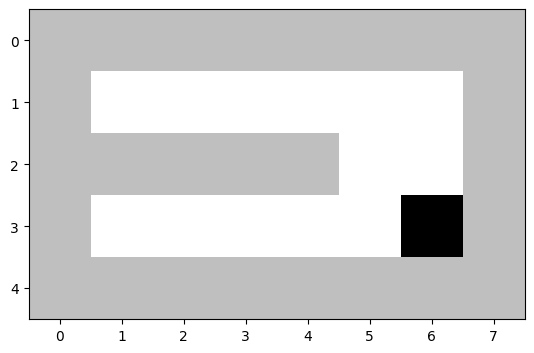

States: 144, Actions: 4, Observations 32, Thetas [(1, 1), (2, 1)]

setting reward function

setting transition function

setting observation function

transition probability shape:  torch.Size([144, 4, 144])
reward shape:  torch.Size([144, 4, 144])
observation shape:  torch.Size([144, 4, 32])


In [2]:
# maze size
N = 2

# thetas deformations (range(a,b),range(c,d))
l0 = 1
h0 = 3
l1 = 1
h1 = 2

maze = create_maze(N)
env = GridEnvDeform(maze,l0,h0,l1,h1)
env.render()

states = [((x,y,phi),(i,j)) for x in range(1,env.max_shape[0]-1) for y in range(1,env.max_shape[1]-1) for phi in range(4) for i in range(l0,h0) for j in range(l1,h1)] 
actions = [0,1,2,3]
obs = list(itertools.product([0,1], repeat=5))
thetas = [(i,j) for i in range(l0,h0) for j in range(l1,h1)]

state_dict = {state: i for i, state in enumerate(states)}
obs_dict = {obs : i for i, obs in enumerate(obs)}

# Actions are: 0-listen, 1-open-left, 2-open-right
lenS = len(states)
lenA = len(actions)
lenO = len(obs)

print(f"States: {lenS}, Actions: {lenA}, Observations {lenO}, Thetas {thetas}\n")


print("setting reward function\n")
R = torch.zeros(lenS,lenA,lenS)
for s in range(lenS):
    for a in range(lenA):
        r = env.R(states[s],a)
        for s_ in range(lenS):
            R[s][a][s_] = r

print("setting transition function\n")
T = torch.zeros(lenS,lenA,lenS)
for s, state in enumerate(states):
    for a, action in enumerate(actions):
        for s_, state_ in enumerate(states):
            T[s,a,s_] = env.T(state,action,state_)

print("setting observation function\n")
O = torch.zeros(lenS,lenA,lenO)
for s, state in enumerate(states):
    for o, observation in enumerate(obs):
        prob = env.O(state,action,observation)
        for a, action in enumerate(actions):
            O[s,a,o] = prob 



print("transition probability shape: ", T.shape)
print("reward shape: ", R.shape)
print("observation shape: ", O.shape)



# fully observable train

notice that the train is fully observable, in the following cell each transition is \
(1) the current state \
(2) the action taken \
(3) the reward received \
(4) the next state \
(5) the done flag

where current state is an int (range(0, len(states)))

In [3]:
def evaluate_agent(env : POMDPWrapper_v0, agent : DoubleDQNAgent, num_episodes=10):
    total_rewards = []

    for episode in range(num_episodes):
        state, _ = env.reset()
        episode_reward = 0
        done = False
        c = 25
        while c > 0:
            # Render the environment
            # env.render()

            # Agent takes an action using a greedy policy (without exploration)
            action = agent.choose_action([state])
            obs, reward, done, info = env.step(state, action)
            state = info['actual_state']

            episode_reward += reward
            
            if done or c == 1:
                total_rewards.append(episode_reward)
                print(f"Episode {episode + 1}/{num_episodes}, Reward: {episode_reward}")

            c -= 1
    avg_reward = np.mean(total_rewards)
    print(f"Average Reward over {num_episodes} episodes: {avg_reward}")
    return avg_reward


In [5]:
state_dim = 1
action_dim = 4

agent = DoubleDQNAgent(state_dim, action_dim)

env_wrapper = POMDPWrapper_v0(env, agent, T, O, R)

In [6]:
num_episodes = 100


rewards = []
evalrewards = []

for episode in range(num_episodes):
    #
    #state, _ = env_wrapper.reset()
    
    # when bypassing the wrapper, we need to convert the state to the actual state
    s, _ = env.reset()
    state = state_dict[s]
    
    episode_reward = 0
    done = False
    
    steps = 0
    while not done:
        action = agent.choose_action([state])
        
        # obs, reward, done, info = env_wrapper.step(state, action)
        # next_state = info['actual_state']
        # agent.store_transition([state], action, reward, [next_state], done)
        
        # bypassing the wrapper to get the actual state should be equilvalent to the above
        # remember to reset the environment with the actual state and not the wrapper 
        s_ , reward, done , _, _ = env.step(action, states[state], execute=True)
        next_state = state_dict[s_]
        agent.store_transition([state], action, reward, [next_state], done)

        agent.train()
        state = next_state
        episode_reward += reward
        steps += 1        
        if done or steps > 100:
            agent.update_epsilon()
            rewards.append(episode_reward)
            print(f"Episode {episode + 1}/{num_episodes}, Reward: {episode_reward}, Epsilon: {agent.epsilon:.2f}")
            break
    if episode != 0 and episode % 20 == 0:
        avg_reward = evaluate_agent(env_wrapper, agent)
        evalrewards.append(avg_reward)
        print(f"Episode {episode + 1}/{num_episodes}, Average Reward: {avg_reward}")

print("Training complete.")
print("evalrewards: ", evalrewards)

(1, 1)
Episode 1/100, Reward: -60, Epsilon: 0.99
(1, 1)
Episode 2/100, Reward: -151.5, Epsilon: 0.99
(1, 1)
Episode 3/100, Reward: -15.5, Epsilon: 0.99
(1, 1)
Episode 4/100, Reward: -62.0, Epsilon: 0.98
(1, 1)
Episode 5/100, Reward: -9.5, Epsilon: 0.98
(1, 1)
Episode 6/100, Reward: -10, Epsilon: 0.97
(2, 1)
Episode 7/100, Reward: -2.0, Epsilon: 0.97
(1, 1)
Episode 8/100, Reward: -68.5, Epsilon: 0.96
(1, 1)
Episode 9/100, Reward: -17.5, Epsilon: 0.96
(2, 1)
Episode 10/100, Reward: -0.5, Epsilon: 0.95
(2, 1)
Episode 11/100, Reward: 1, Epsilon: 0.95
(1, 1)
Episode 12/100, Reward: -119.0, Epsilon: 0.94
(2, 1)
Episode 13/100, Reward: -36.0, Epsilon: 0.94
(1, 1)
Episode 14/100, Reward: -37.0, Epsilon: 0.93
(2, 1)
Episode 15/100, Reward: -12.5, Epsilon: 0.93
(2, 1)
Episode 16/100, Reward: -98.5, Epsilon: 0.92
(1, 1)
Episode 17/100, Reward: -28.5, Epsilon: 0.92
(2, 1)
Episode 18/100, Reward: -107.5, Epsilon: 0.91
(1, 1)
Episode 19/100, Reward: -27.0, Epsilon: 0.91
(1, 1)
Episode 20/100, Reward

# rendered evaluation


(1, 1)


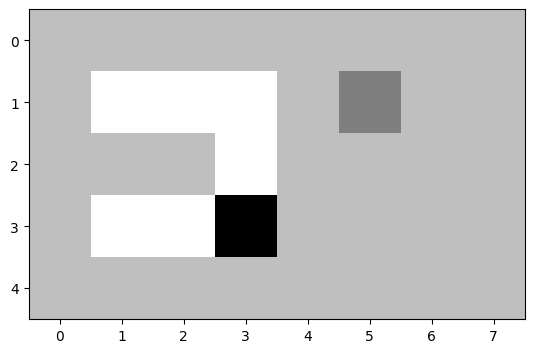

(1, 5, 0)


KeyError: (1, 5, 0)

In [7]:
import time

def evaluate_agent(env : GridEnvDeform, agent : DoubleDQNAgent, num_episodes=10):
    total_rewards = []

    for episode in range(num_episodes):
        s, _ = env.reset()
        env.render()
        episode_reward = 0
        done = False
        c = 25
        while c > 0:
            # Render the environment
            # env.render()

            # Agent takes an action using a greedy policy (without exploration)
            print(s)
            action = agent.choose_action([state_dict[s]])
            s_, reward, done, info = env.step(s, action, execute=True)

            next_state = state_dict[s_]
            state = next_state

            episode_reward += reward
            
            if done or c == 1:
                total_rewards.append(episode_reward)
                print(f"Episode {episode + 1}/{num_episodes}, Reward: {episode_reward}")

            c -= 1
            time.sleep(0.1)
    avg_reward = np.mean(total_rewards)
    print(f"Average Reward over {num_episodes} episodes: {avg_reward}")
    return avg_reward

evaluate_agent(env, agent, 10)


In [10]:
state_dict[s]

123

# transition check

In [30]:
# copy what is done in training:
# start from a random state chose an action and store the transition 
state, _ = env_wrapper.reset()
action = agent.choose_action([state])

obs, reward, done, info = env_wrapper.step(state, action)
next_state = info['actual_state'] # next true state (not observation or belief)

agent.store_transition([state], action, reward, [next_state], done)
state, action, reward, next_state, done


(116, 3, -2.0, 122, False)

((3, 3, 2), (1, 1))


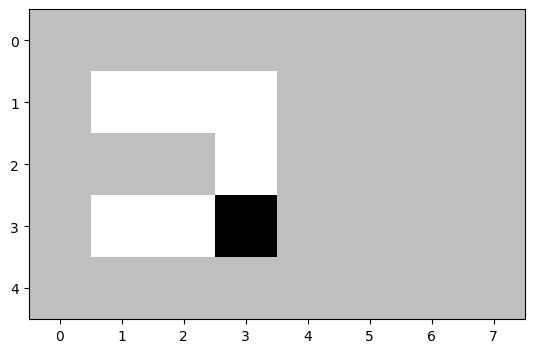

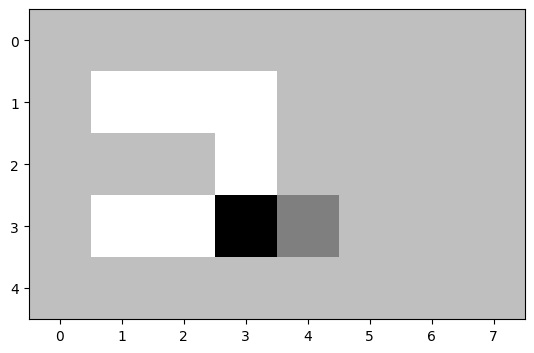

Training transition is  correct


In [31]:
# set state and render
env.set_state(states[state])
print(states[state])
env.render()

# step and render
_ , _, _ , _, _ = env.step(action, states[state], execute=True)
env.render()

# check if the transition is correct
assert env.get_state() == states[next_state]
print("Training transition is ", "correct" if env.get_state() == states[next_state] else "incorrect")